### Load packages and modules

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Define Neural Netowrk Function

In [96]:
##################### Neural Network Implementation

def build_model(no_of_regressors):
    model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[no_of_regressors], kernel_regularizer=keras.regularizers.l1(l=0.1)),
    layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l1(l=0.1)),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse', 'accuracy'])
    return model


###
def predict_nn_reg(data_df, dep_var, indep_var_list, est_sample_end, out_sample_start, EPOCHS = 1000):
    
    """
    data_df: first column is dependent variable, rest of the columns are predictors
    dep_var: name of the dependent variable
    indep_var_list: list of predictors
    
    Outout: returns a dataframe of metrics (change in RMSE, ratio of RMSE and OOS R^2) and dataframe containing actual and predicted values
    """
    
    est_sample_size = data_df[:est_sample_end].shape[0]
    oos_size = data_df[out_sample_start:].shape[0]
    
    # Extract the out-of-sample index
    oos_index = data_df[out_sample_start:].index
    
    # print("est sample size: ", est_sample_size)
    # print("oos sample size: ", oos_size)

    no_of_regressors = len(indep_var_list)
    
    
    # Create an empty data frame to hold the true and predicted values in out-of-sample
    true_pred = []
 
    # tscv = TimeSeriesSplit(n_splits=5)

    est_sample_start_indx = 0
    
    # print(np.arange(oos_size))
    
    # Loop for rolling window recursive estimation     
    for i in np.arange(oos_size):
        
        # print("\n\nValue of i: ", i)
        
        est_sample_end_indx = est_sample_size + i

        # Extract the predictor columns
        predictor_df = data_df.iloc[est_sample_start_indx:est_sample_end_indx][indep_var_list]
        # print("Predictors index: \n", predictor_df.index)
        # print("Predictors tail: \n", predictor_df.tail())
        
        
        X = predictor_df
        # print(X.shape)
        
        # This returns a pandas series
        y = data_df.iloc[est_sample_start_indx:est_sample_end_indx][['y']]
        y = pd.DataFrame(y)
        # print(y.shape)
        # print("Dependent variable index: \n", y.index)
        # print("Dependent variable tail: \n", y.tail())
        

        # Test data point is used for prediction          
        test_data_idx = est_sample_end_indx + 1

        # Extract the actual test data point - it is the next row just where the in-sample data ends
        X_test = data_df.iloc[est_sample_end_indx:test_data_idx][indep_var_list]
        y_test = data_df.iloc[est_sample_end_indx:test_data_idx][['y']]
        y_test = np.asscalar(y_test.values)

        # print("####################")
        # print("X_test: \n", X_test)
        # print("y_test: \n", y_test)

        est_sample_start_indx = est_sample_start_indx + 1
        
        
        #########################################################################################
        ##################### Train with early stopping - to prevent overfitting ################
        # if EARLY_STOPPING == True:
        # print("\nTrain with early stopping - to prevent overfitting")
        model = build_model(no_of_regressors)
        # model.summary()

        # The patience parameter is the amount of epochs to check for improvement
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

        early_history = model.fit(X, y, epochs = EPOCHS, validation_split = 0.25, verbose=0, callbacks=[early_stop])

        early_hist = pd.DataFrame(early_history.history)
        early_hist['epoch'] = early_history.epoch    

        # train_mse = early_hist.iloc[-1]['loss']
        # train_acc = early_hist.iloc[-1]['acc']
        # train_rmse = train_mse**(1/2)

        # Predict the dependent var based on test data point
        y_pred = model.predict(X_test)
        y_pred = np.asscalar(y_pred)
            
        # Put everything together - actual, predicted
        true_pred.append([y_test, y_pred])
        
        
    # Create a dataframe with actual, predicted, historical average, random walk prediction
    true_pred_df = pd.DataFrame(true_pred, columns = ['actual', 'predicted'], index = oos_index)
        
    return(true_pred_df)


#### Read S&P500 Data

In [86]:
# Read SP500 data
sp500 = pd.read_csv("C:\\GoogleDrivePushpakUW\\UW\\TDI\\all_stocks_5yr\\all_stocks_5yr.csv")
sp500 = sp500[['date', 'close', 'Name']]
sp500['date'] = pd.to_datetime(sp500['date'])

print(sp500.head())

        date  close Name
0 2013-02-08  14.75  AAL
1 2013-02-11  14.46  AAL
2 2013-02-12  14.27  AAL
3 2013-02-13  14.66  AAL
4 2013-02-14  13.99  AAL


In [87]:
sp500_long = sp500.pivot(index = 'date', columns='Name', values='close')
print(sp500_long.head())
print(sp500_long.shape)

Name            A    AAL    AAP     AAPL   ABBV    ABC    ABT    ACN   ADBE  \
date                                                                          
2013-02-08  45.08  14.75  78.90  67.8542  36.25  46.89  34.41  73.31  39.12   
2013-02-11  44.60  14.46  78.39  68.5614  35.85  46.76  34.26  73.07  38.64   
2013-02-12  44.62  14.27  78.60  66.8428  35.42  46.96  34.30  73.37  38.89   
2013-02-13  44.75  14.66  78.97  66.7156  35.27  46.64  34.46  73.56  38.81   
2013-02-14  44.58  13.99  78.84  66.6556  36.57  46.77  34.70  73.13  38.61   

Name          ADI  ...       XL   XLNX    XOM   XRAY    XRX    XYL    YUM  \
date               ...                                                      
2013-02-08  45.70  ...    28.24  37.51  88.61  42.87  31.84  27.09  65.30   
2013-02-11  46.08  ...    28.31  37.46  88.28  42.84  31.96  27.46  64.55   
2013-02-12  46.27  ...    28.41  37.58  88.46  42.87  31.84  27.95  64.75   
2013-02-13  46.26  ...    28.42  37.80  88.67  43.08  32.00  

In [88]:
# Calculate log return
log_returns = np.log(sp500_long) - np.log(sp500_long.shift(1))
returns = log_returns.interpolate(axis = 1)

print(returns.head())
print('############')
returns = returns.dropna()
print(returns.head())

Name               A       AAL       AAP      AAPL      ABBV       ABC  \
date                                                                     
2013-02-08       NaN       NaN       NaN       NaN       NaN       NaN   
2013-02-11 -0.010705 -0.019857 -0.006485  0.010368 -0.011096 -0.002776   
2013-02-12  0.000448 -0.013227  0.002675 -0.025386 -0.012067  0.004268   
2013-02-13  0.002909  0.026963  0.004696 -0.001905 -0.004244 -0.006838   
2013-02-14 -0.003806 -0.046780 -0.001648 -0.000900  0.036195  0.002783   

Name             ABT       ACN      ADBE       ADI    ...           XL  \
date                                                  ...                
2013-02-08       NaN       NaN       NaN       NaN    ...          NaN   
2013-02-11 -0.004369 -0.003279 -0.012346  0.008281    ...     0.002476   
2013-02-12  0.001167  0.004097  0.006449  0.004115    ...     0.003526   
2013-02-13  0.004654  0.002586 -0.002059 -0.000216    ...     0.000352   
2013-02-14  0.006940 -0.005863 -0.005

#### Extract 5 PCs from Returns Data

Shape of PC data:  (1258, 5)
How many pcs:  5


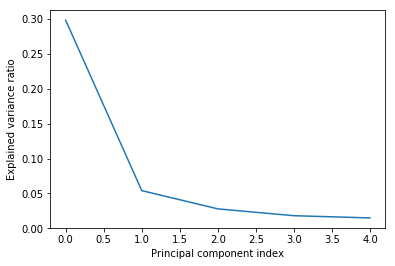

                 PC1       PC2       PC3       PC4       PC5
date                                                        
2013-02-11  2.012173 -0.556482  0.221911  2.178644  0.771916
2013-02-12 -3.819273 -0.435943 -1.653007  2.323843 -0.831509
2013-02-13 -1.651256  1.888082 -2.085322 -1.126927  0.800286
2013-02-14  0.001589  3.311530  0.875841 -1.271180  1.595575
2013-02-15  0.130070 -3.810923  3.097395  0.728566  0.333492
                  PC1        PC2       PC3       PC4       PC5
date                                                          
2018-02-01   3.993658  13.490096  0.470958  2.622057  4.197902
2018-02-02  31.380047   0.092578  2.252972  1.355995  0.712266
2018-02-05  60.317567   3.722265 -3.743164 -2.818051 -2.349867
2018-02-06 -17.723378   8.086578  3.625767 -3.619181 -3.974333
2018-02-07   4.114783   2.194425  5.468112  6.168652 -1.701143


In [89]:
scaler = StandardScaler()
sp500_std = scaler.fit_transform(returns)

# Extract 3 PCs from data
pca = PCA(n_components=5)

pc = pca.fit_transform(sp500_std)
print("Shape of PC data: ", pc.shape)

num_pc = len(pca.components_)
print("How many pcs: ", len(pca.components_))

var = pca.explained_variance_ratio_
plt.plot(var)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()


pc_coef_names = ["PC" + str(i+1) for i in range(num_pc)]

pc_df = pd.DataFrame(pc, columns=pc_coef_names, index=returns.index)
print(pc_df.head())
print(pc_df.tail())

In [90]:
stock_names = returns.columns.tolist()
stock_names = stock_names[0]
print(stock_names)

A


#### Train Neural Network and Produce Out-of-Sample Forecast

In [97]:
fcast_horizon = 1

est_sample_end_date = '2017-12-31'
out_sample_start_date = '2018-01-01'

# Extract the out-of-sample index
oos_index = returns[out_sample_start_date:].index

forecast_nn = pd.DataFrame(index = oos_index)
    

for itr in stock_names:
    # print("Dependent variable: ", itr)    
    # print(returns[[itr]])
    
    ret_df = returns[[itr]]
    ret_df.columns = ['y']
    # print(ret_df.head())
    
    data_df = ret_df.join(pc_df, how = 'inner')
    # print(data_df.head())
    
    predictor_df = data_df[pc_df.columns]
    predictor_lag = predictor_df.shift(periods = fcast_horizon)
    # print(predictor_lag.head())

    reg_df = ret_df.join(predictor_lag, how = 'inner')
    # print(reg_df.head())
    
    reg_df = reg_df.dropna()
    # print(reg_df.head())
    
    indep_var_list = predictor_df.columns.tolist()
    # print(indep_var_list)
    
    dep_var = itr
        
    forecast = predict_nn_reg(data_df = reg_df, dep_var = itr, indep_var_list = indep_var_list, 
                                    est_sample_end = est_sample_end_date, out_sample_start = out_sample_start_date, 
                                    EPOCHS=100)
    print(forecast)
    print('########')
    # forecast_nn = forecast_nn.join(forecast, how = 'inner')
    # print(forecast_nn)


              actual  predicted
date                           
2018-01-02  0.009363  -0.000721
2018-01-03  0.025125  -0.002763
2018-01-04 -0.007530  -0.009792
2018-01-05  0.015862  -0.009474
2018-01-08  0.002144   0.001225
2018-01-09  0.024257  -0.002025
2018-01-10 -0.013749   0.000009
2018-01-11  0.000141  -0.000518
2018-01-12  0.013050   0.001208
2018-01-16 -0.006995  -0.000202
2018-01-17  0.011585  -0.000169
2018-01-18  0.001802   0.001483
2018-01-19  0.012116   0.002242
2018-01-22  0.005595   0.002381
2018-01-23 -0.000545   0.001330
2018-01-24  0.001905   0.001592
2018-01-25  0.003798   0.001852
2018-01-26  0.012914  -0.002216
2018-01-29 -0.003884  -0.002867
2018-01-30 -0.020879  -0.000078
2018-01-31  0.006010   0.000735
2018-02-01 -0.008205  -0.001242
2018-02-02 -0.021933  -0.000547
2018-02-05 -0.043457  -0.001529
2018-02-06  0.003366   0.002286
2018-02-07 -0.005714   0.001536
########


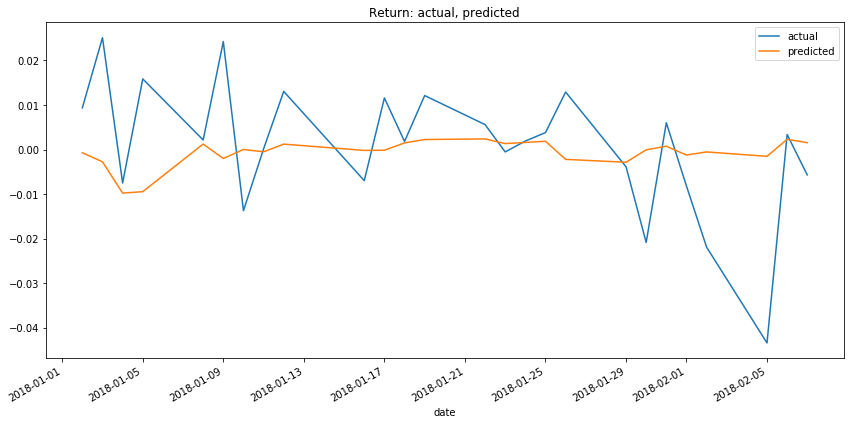

In [98]:
# Plot the actual, predicted and random walk values for the OOS
forecast[['actual', 'predicted']].plot(figsize=(12, 6), title="Return: actual, predicted")
plt.tight_layout(); plt.show()
